# Load the initial Data

In [85]:
df = spark.read.csv('ts.csv', inferSchema=True, header=True, timestampFormat='yyyy-MM-dd HH:mm:ss+ss')

## Transform the timestamp into a unix epoch

In [86]:
df = df.withColumn("timestamp_epoch", df.timestamp.cast("long")).sort('timestamp_epoch')

In [87]:
df.show(20)

+-------------------+-----------+----------------+----------------+--------+---------------+
|          timestamp|  tablet_id|             lat|             lon|activity|timestamp_epoch|
+-------------------+-----------+----------------+----------------+--------+---------------+
|2019-06-12 04:48:00|CH184703916|48.8365266666667|2.52934833333333|Domicile|     1560307680|
|2019-06-12 04:48:00|CH184703916|       48.836355|        2.529325|Domicile|     1560307680|
|2019-06-12 05:32:00|CH184703916|48.8359416666667|2.53005166666667|     Rue|     1560310320|
|2019-06-12 05:32:00|CH184703916|48.8360366666667|         2.52985|     Rue|     1560310320|
|2019-06-12 06:16:00|CH184703916|        48.83648|         2.52973|     Bus|     1560312960|
|2019-06-12 06:23:00|CH184703916|        48.83642|         2.52948|     Rue|     1560313380|
|2019-06-12 06:23:00|CH184703916|48.8363583333333|2.52976666666667|     Rue|     1560313380|
|2019-06-12 06:28:00|CH184703916|48.8359583333333|2.52940333333333|  B

In [34]:
df.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- tablet_id: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- activity: string (nullable = true)
 |-- timestamp_epoch: long (nullable = true)



In [88]:
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql.types import *

## Concatenating the different measures into one column

In [89]:
def concat(*args):
    return [arg for arg in args]
concat_udf = udf(concat, StringType())

In [90]:
cols = [c for c in df.columns if not c.startswith("timestamp") and not c.startswith("lat") and not c.startswith("lon")]
coords = [c for c in df.columns if c.startswith("lat") or c.startswith("lon")]


In [91]:
df1 = df.select('timestamp_epoch', *cols, concat_udf(*coords).alias('coordinates'))

### Droping the duplicated timestamps (instantaneous activities)

In [92]:
df1 = df1.drop_duplicates(['timestamp_epoch']).sort('timestamp_epoch')

In [93]:
df1.count()

724

In [94]:
df1.show(10, False)

+---------------+-----------+--------+------------------------------------+
|timestamp_epoch|tablet_id  |activity|coordinates                         |
+---------------+-----------+--------+------------------------------------+
|1560307680     |CH184703916|Domicile|[48.8365266666667, 2.52934833333333]|
|1560310320     |CH184703916|Rue     |[48.8359416666667, 2.53005166666667]|
|1560312960     |CH184703916|Bus     |[48.83648, 2.52973]                 |
|1560313380     |CH184703916|Rue     |[48.8363583333333, 2.52976666666667]|
|1560313680     |CH184703916|Bureau  |[48.8362033333333, 2.52943]         |
|1560346680     |CH184703916|Rue     |[48.8293983333333, 2.31567833333333]|
|1560348360     |CH184703916|Métro   |[48.8316016666667, 2.31384333333333]|
|1560351480     |CH184703916|Domicile|[48.826745, 2.35515666666667]       |
|1560353760     |CH184703916|Rue     |[48.8270466666667, 2.35503333333333]|
|1560354060     |CH184703916|Magasin |[48.8269083333333, 2.354735]        |
+-----------

In [11]:
import Geohash
print(Geohash.encode(48.8365266666667,2.52934833333333))
print(Geohash.decode(Geohash.encode(48.8365266666667,2.52934833333333)))

u09vcd3v6h6v
(48.836526749655604, 2.529348414391279)


## Statistics about the interval between observations

In [12]:
win = Window.partitionBy().orderBy('timestamp_epoch')
df1 = df1.withColumn('timestamp_previous', lag(df1.timestamp_epoch).over(win))
df1 = df1.withColumn("diff", when(isnull(df1.timestamp_epoch - df1.timestamp_previous), 0)
                              .otherwise(df1.timestamp_epoch - df1.timestamp_previous))
df1.show(10)

+---------------+-----------+--------+--------------------+------------------+-----+
|timestamp_epoch|  tablet_id|activity|         coordinates|timestamp_previous| diff|
+---------------+-----------+--------+--------------------+------------------+-----+
|     1560307680|CH184703916|Domicile|[48.8365266666667...|              null|    0|
|     1560310320|CH184703916|     Rue|[48.8359416666667...|        1560307680| 2640|
|     1560312960|CH184703916|     Bus| [48.83648, 2.52973]|        1560310320| 2640|
|     1560313380|CH184703916|     Rue|[48.8363583333333...|        1560312960|  420|
|     1560313680|CH184703916|  Bureau|[48.8362033333333...|        1560313380|  300|
|     1560346680|CH184703916|     Rue|[48.8293983333333...|        1560313680|33000|
|     1560348360|CH184703916|   Métro|[48.8316016666667...|        1560346680| 1680|
|     1560351480|CH184703916|Domicile|[48.826745, 2.355...|        1560348360| 3120|
|     1560353760|CH184703916|     Rue|[48.8270466666667...|      

### Replace the first value with the mean of the differences

In [13]:
df_tmp = df1.filter(df1.timestamp_epoch != df1.first()[0])
df1 = df1.withColumn('diff', when(df1.diff == 0, df_tmp.agg(avg('diff')).first()[0]).otherwise(df1.diff))
df1.show(10)

+---------------+-----------+--------+--------------------+------------------+------------------+
|timestamp_epoch|  tablet_id|activity|         coordinates|timestamp_previous|              diff|
+---------------+-----------+--------+--------------------+------------------+------------------+
|     1560307680|CH184703916|Domicile|[48.8365266666667...|              null|11178.340248962655|
|     1560310320|CH184703916|     Rue|[48.8359416666667...|        1560307680|            2640.0|
|     1560312960|CH184703916|     Bus| [48.83648, 2.52973]|        1560310320|            2640.0|
|     1560313380|CH184703916|     Rue|[48.8363583333333...|        1560312960|             420.0|
|     1560313680|CH184703916|  Bureau|[48.8362033333333...|        1560313380|             300.0|
|     1560346680|CH184703916|     Rue|[48.8293983333333...|        1560313680|           33000.0|
|     1560348360|CH184703916|   Métro|[48.8316016666667...|        1560346680|            1680.0|
|     1560351480|CH1

In [14]:
df1.select('diff').summary().show()

+-------+------------------+
|summary|              diff|
+-------+------------------+
|  count|               724|
|   mean|11178.340248962655|
| stddev|159363.34935999848|
|    min|              60.0|
|    25%|             360.0|
|    50%|             960.0|
|    75%|            2640.0|
|    max|         4275120.0|
+-------+------------------+



### Summary
There is one difference that equals to 4275120 seconds (almost 50 days). So the different is really very wide between the minimum difference 60 seconds and the biggest one 50 days. If we drop the 50 days difference, we will have the summary below.

In [15]:
df1 = df1.filter(df1.diff < 623640)
df1.select('diff').summary().show()

+-------+------------------+
|summary|              diff|
+-------+------------------+
|  count|               723|
|   mean| 5280.772254839506|
| stddev|14673.368643557595|
|    min|              60.0|
|    25%|             360.0|
|    50%|             960.0|
|    75%|            2640.0|
|    max|          211620.0|
+-------+------------------+



Still the average is 5280 seconds (88 minutes), where the maximum value is 211620 seconds (almost 2 days and a half), the minimum is always 60 seconds.
I will go with the minimum interval for the time being and missing values will be null

In [16]:
import pandas as pd
from matplotlib import pyplot as plt

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4449ab77f0>]],
      dtype=object)

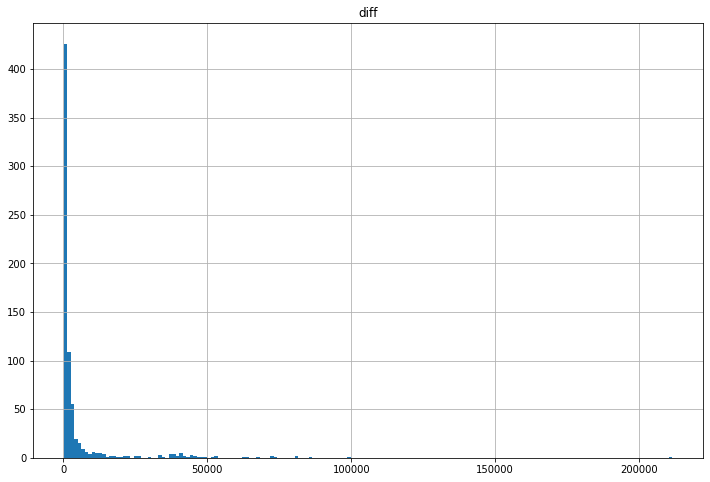

In [17]:
pdf = df1.select('diff').toPandas()
pdf.hist(bins=pdf['diff'].nunique(), figsize=(12,8))

In [18]:
pdf['diff'].value_counts()

120.0      38
180.0      37
60.0       35
240.0      34
480.0      31
360.0      30
420.0      28
300.0      27
720.0      16
840.0      15
780.0      15
900.0      15
1020.0     15
660.0      14
960.0      14
1200.0     13
1080.0     12
600.0      12
540.0      12
1860.0     10
1320.0      9
1140.0      8
1500.0      8
1560.0      7
1440.0      7
3120.0      6
2100.0      6
2220.0      6
1800.0      6
1980.0      6
           ..
20940.0     1
37800.0     1
30000.0     1
21840.0     1
8340.0      1
81480.0     1
24480.0     1
6780.0      1
20460.0     1
36600.0     1
44820.0     1
12420.0     1
8520.0      1
72960.0     1
4200.0      1
7920.0      1
5280.0      1
40620.0     1
86340.0     1
40080.0     1
53220.0     1
33360.0     1
49560.0     1
15720.0     1
36840.0     1
45240.0     1
12900.0     1
33000.0     1
9480.0      1
68040.0     1
Name: diff, Length: 174, dtype: int64

In [112]:
step = 1 * 60
inner_granularity = 'minute'
minp, maxp = df1.select(min("timestamp_epoch"), max("timestamp_epoch")).first()

reference = spark.range(
    (minp / step) * step, ((maxp / step) + 1) * step, step).select(col("id").cast("timestamp").cast("long").alias("timestamp"))


df_joined = reference.join(df1,reference.timestamp == df1.timestamp_epoch, "leftouter").drop('timestamp_previous',
                                                                                             'diff', 'timestamp_epoch')

# df_joined = reference.join(df1,reference.timestamp == df1.timestamp_epoch, "inner").drop('timestamp_previous',
#                                                                                              'diff', 'timestamp_epoch')

df_joined.show()

+----------+-----------+--------+--------------------+
| timestamp|  tablet_id|activity|         coordinates|
+----------+-----------+--------+--------------------+
|1560307680|CH184703916|Domicile|[48.8365266666667...|
|1560307740|       null|    null|                null|
|1560307800|       null|    null|                null|
|1560307860|       null|    null|                null|
|1560307920|       null|    null|                null|
|1560307980|       null|    null|                null|
|1560308040|       null|    null|                null|
|1560308100|       null|    null|                null|
|1560308160|       null|    null|                null|
|1560308220|       null|    null|                null|
|1560308280|       null|    null|                null|
|1560308340|       null|    null|                null|
|1560308400|       null|    null|                null|
|1560308460|       null|    null|                null|
|1560308520|       null|    null|                null|
|156030858

In [16]:
x, y = df_joined.count(), df_joined.filter(isnull('activity')).count()
print("missing values percentage:", (y*100)/x)

missing values percentage: 0.0


In [113]:
df_joined = df_joined.na.fill('null')

# Doing the Temporal Indexing

In [114]:
def groupPerGranularity(granularity):
    inSec = 86400 # By default day
    if granularity == 'year':
        inSec = 31536000
    elif granularity == 'month':
        inSec = 2630000
    elif granularity == 'week':
        inSec = 604800
    elif granulaity == 'hour':
        inSec = 3600
    elif granularity == 'minute':
        inSec = 60
    elif granularity == 'second':
        inSec = 1
    return (floor(df_joined.timestamp / lit(inSec)) * lit(inSec)).alias('timestamp_interval')

In [115]:
granularity = 'month'
tsGroup = groupPerGranularity(granularity)

In [116]:
getFirst = udf(lambda x:x[0], StringType())

In [54]:
columns = ['tablet_id', 'activity', 'coordinates']

In [55]:
a = [collect_list(c).alias(c) for c in columns]

In [100]:
df_joined.show()

+----------+-----------+--------+--------------------+
| timestamp|  tablet_id|activity|         coordinates|
+----------+-----------+--------+--------------------+
|1560307680|CH184703916|Domicile|[48.8365266666667...|
|1560307740|       null|    null|                null|
|1560307800|       null|    null|                null|
|1560307860|       null|    null|                null|
|1560307920|       null|    null|                null|
|1560307980|       null|    null|                null|
|1560308040|       null|    null|                null|
|1560308100|       null|    null|                null|
|1560308160|       null|    null|                null|
|1560308220|       null|    null|                null|
|1560308280|       null|    null|                null|
|1560308340|       null|    null|                null|
|1560308400|       null|    null|                null|
|1560308460|       null|    null|                null|
|1560308520|       null|    null|                null|
|156030858

In [101]:
df_joined.agg(collect_list('coordinates')).show()

+-------------------------+
|collect_list(coordinates)|
+-------------------------+
|     [[48.836526666666...|
+-------------------------+



In [117]:

df2 = (df_joined.groupBy(tsGroup).agg(
    collect_list('tablet_id').alias('tablet_id'),
    collect_list('activity').alias('activity'),
    collect_list('coordinates').alias('coordinates'),
    collect_list('timestamp').alias('timestamp_first'))).withColumn('timestamp_first', 
                                                                          getFirst('timestamp_first')).orderBy('timestamp_first')

In [103]:
t = df2.withColumn('l1', size('tablet_id')).withColumn('l2', size('activity')).withColumn('l3', size('coordinates'))

In [104]:
t.select('l1', 'l2', 'l3').show()

+-----+-----+-----+
|   l1|   l2|   l3|
+-----+-----+-----+
|31872|31872|31872|
|43834|43834|43834|
|43833|43833|43833|
|15161|15161|15161|
+-----+-----+-----+



In [118]:
df2 = df2.withColumn('global_granularity', lit('1 month'))
df2 = df2.withColumn('inner_granularity', lit('1 minute'))

In [106]:
df2.show(2)

+------------------+--------------------+--------------------+--------------------+---------------+------------------+-----------------+
|timestamp_interval|           tablet_id|            activity|         coordinates|timestamp_first|global_granularity|inner_granularity|
+------------------+--------------------+--------------------+--------------------+---------------+------------------+-----------------+
|        1559590000|[CH184703916, nul...|[Domicile, null, ...|[[48.836526666666...|     1560307680|             month|           minute|
|        1562220000|[null, null, null...|[null, null, null...|[null, null, null...|     1562220000|             month|           minute|
+------------------+--------------------+--------------------+--------------------+---------------+------------------+-----------------+
only showing top 2 rows



In [119]:
df2.write.mode('overwrite').partitionBy('timestamp_interval').parquet('tss_null')